- Manually gen rules for amazon (sample some rows if taking too long) – just test with snorkel, no repair needed
- Create a utility to test the candidate rule accuracies 
- Test them by adding / accumulating them to see if we see improvement in global accuracy etc. Based on the results , we can see what rules from r_{gold} can the current algorithm produce. Then use r_{gold} as starting point and test via subset of rules.
- Compare r_{gold} with r_{witan}


Step 1: gen rules based on some samples:
Required components:
- A sampler to get sampled sentences from the dataset (sentence, ground truth label)
- A template for user to write
- Translate to TreeRule objects
- Test utility to gen accuracy on the dataset for this candidate LF

Step 2: given a list of rules (TreeRules), actually run with Snorkel to see the results
Required components:
- A way to specify the list of rules (could be pickle file and display user-friendly formats in order for user to specify?)
- Save the ruleset with a filename

In [3]:
# the original Amazon global accuracy with witan rules(15) is 0.64

In [4]:
from rbbm_src.labelling_func_src.src.lfs_tree import keyword_labelling_func_builder
from rbbm_src.labelling_func_src.src.TreeRules import SPAM, HAM
from rbbm_src.labelling_func_src.src.LFRepair import run_snorkel
from rbbm_src.labelling_func_src.src.classes import clean_text
import re
import pandas as pd
import psycopg2
import pandas as pd
from snorkel.labeling import (
	LabelingFunction, 
	labeling_function, 
	PandasLFApplier, 
	LFAnalysis,
	filter_unlabeled_dataframe
	)
from snorkel.labeling.model import MajorityLabelVoter, LabelModel

[nltk_data] Downloading package words to /home/opc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/opc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-08-05 04:21:28.189249: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 04:21:28.239866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 04:21:28.241273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
DEBUG 2024-08-05 04:21:28,988 [tpu_cluster_resolver.py:<module>:32] Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install c

In [5]:
from rbbm_src.labelling_func_src.src.example_tree_rules import gen_amazon_funcs

In [6]:
def calculate_coverage(df, lf_column):
    total_instances = len(df)
    labeled_instances = df[lf_column] != -1
    coverage = labeled_instances.sum() / total_instances
    return coverage

def calculate_accuracy(df, lf_column, ground_truth_column):
    labeled_instances = df[df[lf_column] != -1]
    correct_labels = (labeled_instances[lf_column] == labeled_instances[ground_truth_column]).sum()
    total_labeled = len(labeled_instances)
    if total_labeled == 0:
        return 0.0  # Avoid division by zero if no instances are labeled
    accuracy = correct_labels / total_labeled
    return accuracy

In [7]:
# mapping_dict = {'negative':SPAM, 'positive':HAM}

In [8]:
# kwords_and_label_re = re.compile('\((.*)\)->(\w+)')

In [9]:
# kwords_and_label_re.search('(common,subscribe)->negative').groups()

In [10]:
# load amazon dataset

In [11]:
conn = psycopg2.connect(dbname='label', user='postgres')

In [12]:
sentences_df=pd.read_sql(f'SELECT * FROM amazon01', conn)
sentences_df = sentences_df.rename(columns={"class": "expected_label", "content": "old_text"})
sentences_df['text'] = sentences_df['old_text'].apply(lambda s: clean_text(s))
sentences_df = sentences_df[~sentences_df['text'].isna()]

/tmp/ipykernel_430/3647735799.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM amazon01', conn)


In [13]:
# individual lf accuracies on data

In [14]:
from collections import defaultdict

In [15]:
individual_func_stats = defaultdict(dict)

In [16]:
amazon_treerules = gen_amazon_funcs()

In [17]:
amazon_funcs = [f.gen_label_rule() for f in amazon_treerules]

In [18]:
for f in amazon_funcs:
    print(f)
    sentences_df['lf_labeled'] = sentences_df.apply(f, axis=1)
    cov=calculate_coverage(df=sentences_df, lf_column='lf_labeled')
    acc=calculate_accuracy(df=sentences_df, lf_column='lf_labeled', ground_truth_column='expected_label')
    individual_func_stats[f]={'cov':cov, 'acc':acc}
    print(f"cov:{round(cov,2)}, acc:{round(acc,2)}")
    print('\n')

PredicateNode(id=1, pred=keyword_predicate-word-(star,stars))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.28, acc:0.55


PredicateNode(id=1, pred=keyword_predicate-word-(product,fit,quality,size,cheap,wear))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=1)
cov:0.29, acc:0.54


PredicateNode(id=1, pred=keyword_predicate-word-(great))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.21, acc:0.82


PredicateNode(id=1, pred=keyword_predicate-word-(great))
    LabelNode(id=2, label=-1)
    PredicateNode(id=3, pred=keyword_predicate-word-(stars,works))
        LabelNode(id=4, label=-1)
        LabelNode(id=5, label=0)
cov:0.06, acc:0.91


PredicateNode(id=1, pred=keyword_predicate-word-(waste))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=1)
cov:0.05, acc:0.97


PredicateNode(id=1, pred=keyword_predicate-word-(shoes,item,price,comfortable,plastic))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.14, acc:0.54


Predica

In [19]:
applier = PandasLFApplier(lfs=amazon_funcs)
initial_vectors = applier.apply(df=sentences_df, progress_bar=False)
model = LabelModel(cardinality=2, verbose=True, device='cpu')
model.fit(L_train=initial_vectors, n_epochs=500, log_freq=100, seed=123)

probs_test= model.predict_proba(L=initial_vectors)


INFO 2024-08-05 04:22:02,875 [label_model.py:fit:905] Computing O...
INFO 2024-08-05 04:22:02,884 [label_model.py:fit:911] Estimating \mu...
 55%|████████████████████████████▍                       | 273/500 [00:00<00:00, 866.43epoch/s]INFO 2024-08-05 04:22:03,313 [logger.py:log:79] [300 epochs]: TRAIN:[loss=0.033]
INFO 2024-08-05 04:22:03,389 [logger.py:log:79] [400 epochs]: TRAIN:[loss=0.033]
100%|████████████████████████████████████████████████████| 500/500 [00:00<00:00, 862.80epoch/s]
INFO 2024-08-05 04:22:03,469 [label_model.py:fit:977] Finished Training


In [20]:
# import importlib

# # Determine the module name
# module_name = filter_unlabeled_dataframe.__module__

# # Import the module by name
# module = importlib.import_module(module_name)

# # Print the file path of the module
# print(module.__file__)

In [22]:
df_sentences_filtered, probs_test_filtered, filtered_vectors, df_no_signal  = filter_unlabeled_dataframe(
        X=sentences_df, y=probs_test, L=initial_vectors
)	

df_sentences_filtered = df_sentences_filtered.reset_index(drop=True)
prob_diffs = [abs(t[0]-t[1]) for t in probs_test_filtered]
prob_diffs_tuples = [(t[0],t[1]) for t in probs_test_filtered]
df_sentences_filtered['model_pred_diff'] = pd.Series(prob_diffs)
df_sentences_filtered['model_pred_prob_tuple'] = pd.Series(prob_diffs_tuples)
df_sentences_filtered['model_pred'] = pd.Series(model.predict(L=filtered_vectors))

wrong_preds = df_sentences_filtered[(df_sentences_filtered['expected_label']!=df_sentences_filtered['model_pred'])]
# df_sentences_filtered.to_csv('predictions_shakira.csv', index=False)
# logger.critical(wrong_preds)
accuracy=(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)

print(f"""
    out of {len(sentences_df)} sentences, {len(df_sentences_filtered)} actually got at least one signal to \n
    make prediction. Out of all the valid predictions, we have {len(wrong_preds)} wrong predictions, \n
    accuracy = {(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)} 
    """)


    out of 19946 sentences, 18915 actually got at least one signal to 

    make prediction. Out of all the valid predictions, we have 6918 wrong predictions, 

    accuracy = 0.6342585249801744 
    


In [23]:
# add signal label count distributions + snorkel prediction

In [24]:
# Analyze the labels
analysis = LFAnalysis(L=initial_vectors, lfs=amazon_funcs)
analysis.lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
"PredicateNode(id=1, pred=keyword_predicate-word-(star,stars))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",0,[0],0.282463,0.225709,0.175173
"PredicateNode(id=1, pred=keyword_predicate-word-(product,fit,quality,size,cheap,wear))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",1,[1],0.290635,0.281911,0.207410
"PredicateNode(id=1, pred=keyword_predicate-word-(great))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",2,[0],0.206457,0.191768,0.162288
"PredicateNode(id=1, pred=keyword_predicate-word-(great))\n LabelNode(id=2, label=-1)\n PredicateNode(id=3, pred=keyword_predicate-word-(stars,works))\n LabelNode(id=4, label=-1)\n LabelNode(id=5, label=0)",3,[0],0.055149,0.055149,0.040058
"PredicateNode(id=1, pred=keyword_predicate-word-(waste))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",4,[1],0.049283,0.047729,0.020906
"PredicateNode(id=1, pred=keyword_predicate-word-(shoes,item,price,comfortable,plastic))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",5,[0],0.138775,0.135566,0.123233
"PredicateNode(id=1, pred=keyword_predicate-word-(junk,bought,like,dont,just,use,buy,work,small,didnt,did,disappointed))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",6,[1],0.626090,0.544320,0.395969
"PredicateNode(id=0, pred=keyword_predicate-word-(junk,bought,like,dont,just,use,buy,work,small,didnt,did,disappointed))\n LabelNode(id=2, label=-1)\n PredicateNode(id=3, pred=keyword_predicate-word-(shoes,metal,fabric,replace,battery,warranty,plug))\n LabelNode(id=4, label=-1)\n LabelNode(id=5, label=1)",7,[1],0.069287,0.069287,0.051389
"PredicateNode(id=1, pred=keyword_predicate-word-(love,perfect,loved,nice,excellent,works,loves,awesome,easy))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",8,[0],0.349042,0.323524,0.274892
"PredicateNode(id=1, pred=keyword_predicate-word-(love,perfect,loved,nice,excellent,works,loves,awesome,easy))\n LabelNode(id=2, label=-1)\n PredicateNode(id=3, pred=keyword_predicate-word-(stars,soft))\n LabelNode(id=4, label=-1)\n LabelNode(id=5, label=0)",9,[0],0.071794,0.071794,0.042214


In [25]:
lf_vectors = filtered_vectors
ground_truth = df_sentences_filtered['expected_label']
snorkel_predictions = df_sentences_filtered['model_pred']

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Define the abstain label
abstain_label = -1

DEBUG 2024-08-05 10:30:59,479 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-05 10:30:59,480 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:30:59,490 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-05 10:30:59,491 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
DEBUG 2024-

DEBUG 2024-08-05 10:31:00,230 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
DEBUG 2024-08-05 10:31:00,233 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-05 10:31:00,233 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:31:00,253 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-

DEBUG 2024-08-05 10:31:00,499 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-05 10:31:00,500 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:31:00,502 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-05 10:31:00,503 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
DEBUG 2024-

DEBUG 2024-08-05 10:31:00,651 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-05 10:31:00,651 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:31:00,694 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-05 10:31:00,695 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:31:00,697 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-05 10:31:00,698 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e

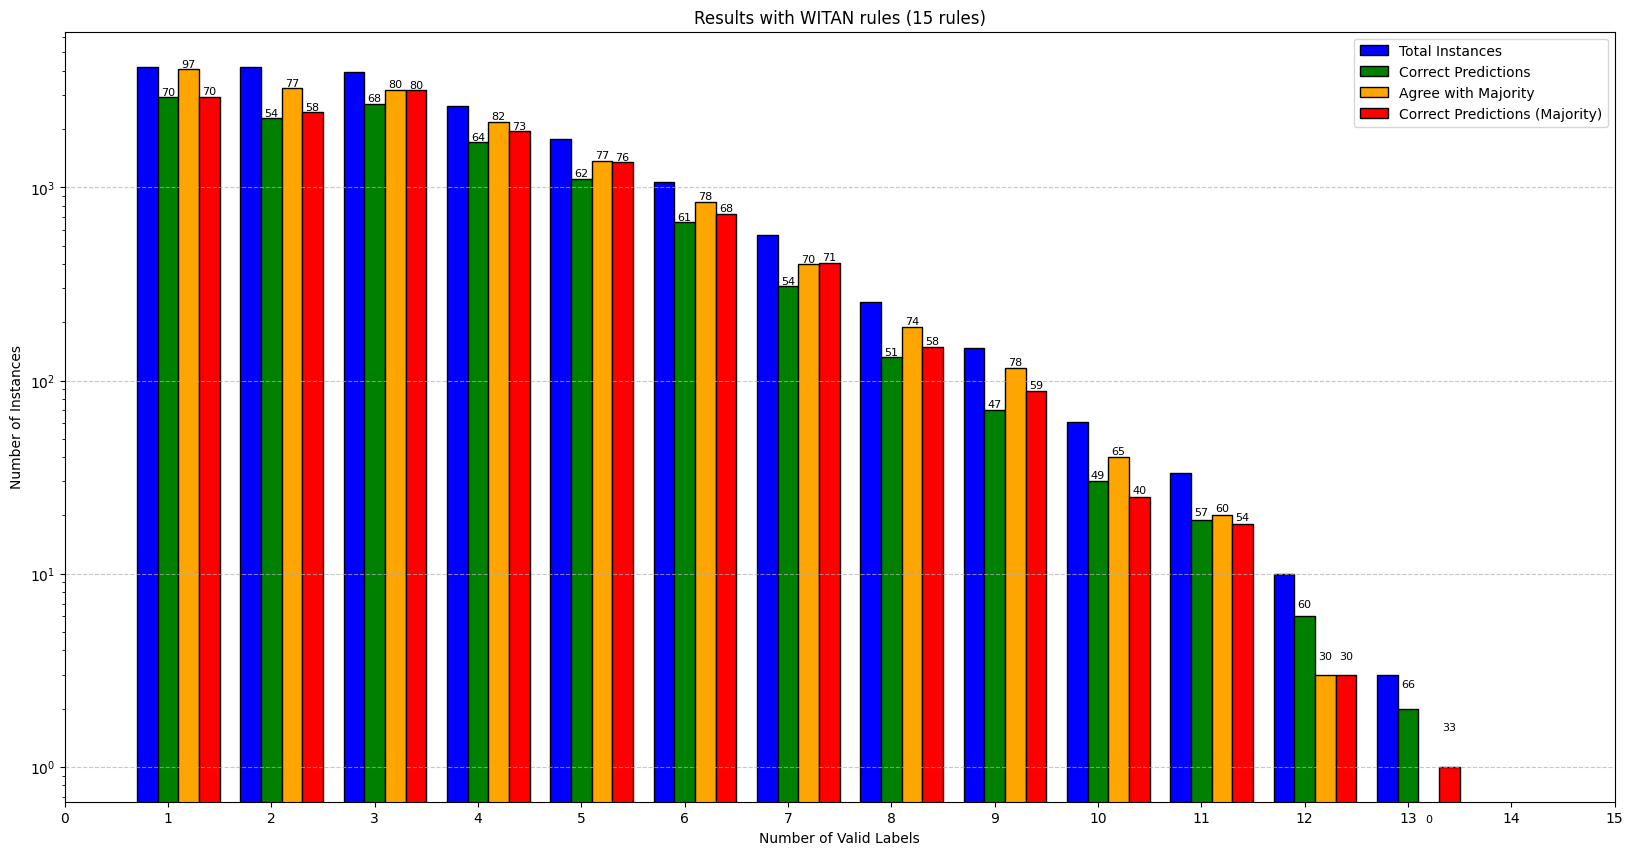

In [50]:

from collections import Counter


# Define the abstain label
abstain_label = -1

# Calculate the majority vote for each instance
def majority_vote(labels):
    valid_labels = [label for label in labels if label != abstain_label]
    if valid_labels:
        return Counter(valid_labels).most_common(1)[0][0]
    else:
        return abstain_label

majority_votes = np.array([majority_vote(row) for row in lf_vectors])

# Count the number of valid (non-abstain) labels for each instance
valid_label_counts = np.sum(lf_vectors != abstain_label, axis=1)

# Determine the number of correct Snorkel predictions
correct_predictions = (snorkel_predictions == ground_truth)

# Determine the number of Snorkel predictions that agree with the majority vote
agree_with_majority = (snorkel_predictions == majority_votes)

# correct majority results
correct_majority_predictions = (majority_votes == ground_truth)

# Count the total instances, correct predictions, and agreements with majority vote for each number of valid labels
max_valid_labels = 27
total_counts = Counter(valid_label_counts)
correct_counts = Counter(valid_label_counts[correct_predictions])
agree_counts = Counter(valid_label_counts[agree_with_majority])
correct_majority_counts = Counter(valid_label_counts[correct_majority_predictions])


# Prepare data for plotting
x = np.arange(max_valid_labels + 1)
total_instances = np.array([total_counts[i] for i in x])
correct_instances = np.array([correct_counts[i] for i in x])
agree_instances = np.array([agree_counts[i] for i in x])
correct_majority_instances = np.array([correct_majority_counts[i] for i in x])


# Calculate the ratio for annotations
ratios_correct = np.divide(correct_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances != 0)
ratios_agree = np.divide(agree_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances != 0)
ratios_correct_majority = np.divide(correct_majority_instances, total_instances, out=np.zeros_like(correct_majority_instances, dtype=float), where=total_instances != 0)


plt.figure(figsize=(20, 10))
bar_width = 0.2  # Increase the bar width
total_bars = plt.bar(x - bar_width, total_instances, bar_width, label='Total Instances', color='blue', edgecolor='black')
correct_bars = plt.bar(x, correct_instances, bar_width, label='Correct Predictions', color='green', edgecolor='black')
agree_bars = plt.bar(x + bar_width, agree_instances, bar_width, label='Agree with Majority', color='orange', edgecolor='black')
correct_majority_bars = plt.bar(x + 2 * bar_width, correct_majority_instances, bar_width, label='Correct Predictions (Majority)', color='red', edgecolor='black')


plt.xlabel('Number of Valid Labels')
plt.ylabel('Number of Instances')
plt.title('Results with WITAN rules (15 rules)')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Limit the x-axis range
plt.xlim(0, 15)  # Adjust the range as needed
plt.yscale('log')
# Add annotations for the ratios
for i in range(len(x)):
    if total_instances[i] > 0:  # Only add text if there are instances
        plt.text(x[i], correct_instances[i] + 0.5, f'{int(ratios_correct[i]*100)}', ha='center', va='bottom', fontsize=8)
        plt.text(x[i] + bar_width, agree_instances[i] + 0.5, f'{int(ratios_agree[i]*100)}', ha='center', va='bottom', fontsize=8)
        plt.text(x[i] + 2 * bar_width, correct_majority_instances[i] + 0.5, f'{int(ratios_correct_majority[i]*100)}', ha='center', va='bottom', fontsize=8, color='black')
plt.savefig('distribution_of_labels_witan_rules_only.pdf', format='pdf')
plt.show()


In [51]:
sum([v for v in correct_majority_counts.values()])

13325

In [52]:
lf_vectors.shape

(18915, 15)

In [53]:
13325/18915

0.7044673539518901